 # First raw analysis 

In [1]:
%run 20_testing_different_bandwidths.ipynb

data_folder = ..\Psychopy_data\exp\B_theta


Un sous-r‚pertoire ou un fichier -p existe d‚j….
Une erreur s'est produite lors du traitement deÿ: -p.
Un sous-r‚pertoire ou un fichier tmp existe d‚j….
Une erreur s'est produite lors du traitement deÿ: tmp.


Overwriting tmp/20_testing_different_bandwidths.py


Un sous-r‚pertoire ou un fichier -p existe d‚j….
Une erreur s'est produite lors du traitement deÿ: -p.
Un sous-r‚pertoire ou un fichier ..\Psychopy_data\exp\B_theta existe d‚j….
Une erreur s'est produite lors du traitement deÿ: ..\Psychopy_data\exp\B_theta.



 Initializing
B_thetas =  [0.06981317 0.13962634 0.20943951 0.27925268 0.34906585 0.41887902
 0.48869219 0.55850536 0.62831853 0.6981317  0.76794487 0.83775804
 0.90757121 0.97738438 1.04719755]
B_sfs =  [0.5]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
#put the code corresponding to your participants

subj_name_list =  ['HL','JM','MP','CR','JF']

subj_data_list = []
import json
for subject in subj_name_list :
    x = json.load(open(os.path.join(data_folder, 'Psychophys_discrim_%s.json' % subject), 'rb'))
     #changer et mettre le path du fichier où se trouve les psychophysic data
    subj_data_list.append(x)

In [4]:
B_theta_list = []
for x in subj_data_list[0] :
    B_theta_list.append(x[3]*180/np.pi)
B_theta_list = sorted(set(B_theta_list))

print('B_theta_list=', B_theta_list)
B_sf_list = []
for x in subj_data_list[0] :
    B_sf_list.append(x[4])
B_sf_list = sorted(set(B_sf_list))
print('B_sf_list=', B_sf_list)

B_theta_list= [3.9999999999999996, 7.999999999999999, 12.0, 15.999999999999998, 19.999999999999996, 24.0, 28.0, 31.999999999999996, 35.99999999999999, 39.99999999999999, 43.99999999999999, 48.0, 51.99999999999999, 56.0, 59.99999999999999]
B_sf_list= [0.5]


In [5]:
# % correct answer

data_dict = {}

for num, data in enumerate(subj_data_list) :
    data_dict[num] = {}
    N_data = len(data)
    data_dict[num]['theta'] = np.zeros((1, N_data))
    data_dict[num]['conditions'] = np.zeros((1, N_data)).astype(np.int)
    data_dict[num]['response'] = np.zeros((1, N_data))
    data_dict[num]['correct'] = np.zeros((1, N_data))
    for i, item in enumerate(data):
        #print(i, item)
        data_dict[num]['theta'][0, i] = item[1]*180/np.pi
        data_dict[num]['conditions'][0, i] = item[5]+item[6]*len(B_theta_list)
        data_dict[num]['response'][0, i] = 1 if item[2] == 'right' else 0
        data_dict[num]['correct'][0, i] = (item[1]>0) if item[2] == 'right' else (item[1]<0)     
    correct = data_dict[num]['correct'].mean()
    print(f'Subject {num} has {correct*100:.3f} % correct overall')

Subject 0 has 70.133 % correct overall
Subject 1 has 77.200 % correct overall
Subject 2 has 82.133 % correct overall
Subject 3 has 86.133 % correct overall
Subject 4 has 86.933 % correct overall


--> observer num 0
--> observer num 1
--> observer num 2
--> observer num 3
--> observer num 4


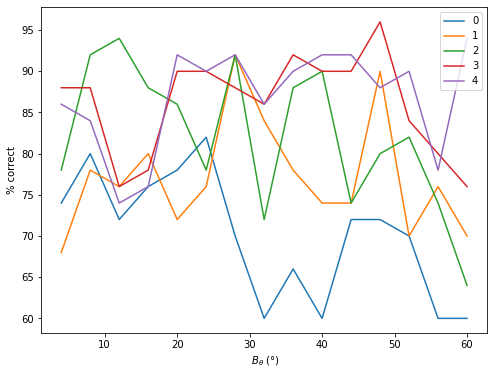

In [6]:
plt.figure(figsize = (8,6)) 
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    correct = data_dict[num]['correct'].reshape((15, 1, 50))
    for i_B_sf, B_sf in enumerate(B_sf_list):
        plt.plot(B_theta_list, correct[:, i_B_sf, :].mean(axis=-1)*100, label=num)
plt.xlabel(r' $B_\theta$ (°)')
plt.ylabel(r' % correct ')
plt.legend(loc ='best') ;

## Fit

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="sum")

N_conditions = len(B_sf_list)*len(B_theta_list)
bias = True
logit0_init, theta0_init, log_wt_init = -np.log(1/.10 - 1), 0.0, np.log(4.)

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0_init, theta0_init, log_wt_init, bias=True):
        super(LogisticRegressionModel, self).__init__()
        if bias:
            self.theta0 = torch.nn.Parameter(theta0_init)
        else:
            self.theta0 = theta0_init
        self.logit0 = torch.nn.Parameter(logit0_init)
        self.log_wt = torch.nn.Parameter(log_wt_init)
        self.do_indep = self.logit0.shape.numel() > 1
        
    def forward(self, theta, i_condition):
        if self.do_indep:
            p0 = torch.sigmoid(self.logit0[i_condition.to(int)])
        else:
            p0 = torch.sigmoid(self.logit0)
            
        theta0 = self.theta0[i_condition.to(int)]
        wt = torch.exp(self.log_wt[i_condition.to(int)])
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-theta0)/wt)
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 12 + 1

def fit_data(logistic_model,
    theta, ind_condition, y,
    learning_rate=learning_rate,
    # batch_size=batch_size,  # previous notebook showed that learning_rate had no influence on performance
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.ByteTensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Theta, Ind_condition, labels = Theta.to(device), Ind_condition.to(device), labels.to(device)        
    
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas)
            
    for epoch in range(int(num_epochs)):
        outputs = logistic_model(Theta, Ind_condition)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {loss.item() /len(theta):.5f}")
            losses = []

    logistic_model.eval()
    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.Tensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta, Ind_condition)
    loss = criterion(outputs, labels).item() / len(theta)
    logistic_model.cpu()
    return logistic_model, loss

In [8]:
bias = False
logit0_init = logit0_init * torch.ones(1)
results = {}
for num, data in enumerate(subj_data_list) :
    logistic_model = LogisticRegressionModel(logit0_init * torch.ones(1), theta0_init*torch.ones(N_conditions), torch.log(log_wt_init*torch.ones(N_conditions)), bias=bias)
    logistic_model, loss = fit_data(logistic_model, data_dict[num]['theta'], 
                                    data_dict[num]['conditions'], 
                                    data_dict[num]['response'], verbose=True)
    results[num] = logistic_model
    print("Final loss =", loss)

Iteration: 0 - Loss: 629.75305
Iteration: 128 - Loss: 529.33276
Iteration: 256 - Loss: 470.61243
Iteration: 384 - Loss: 451.22680
Iteration: 512 - Loss: 446.93513
Iteration: 640 - Loss: 445.86047
Iteration: 768 - Loss: 445.50694
Iteration: 896 - Loss: 445.35756
Iteration: 1024 - Loss: 445.28126
Iteration: 1152 - Loss: 445.23688
Iteration: 1280 - Loss: 445.20860
Iteration: 1408 - Loss: 445.18918
Iteration: 1536 - Loss: 445.17474
Iteration: 1664 - Loss: 445.16276
Iteration: 1792 - Loss: 445.15055
Iteration: 1920 - Loss: 445.12776
Iteration: 2048 - Loss: 444.76231
Iteration: 2176 - Loss: 443.62435
Iteration: 2304 - Loss: 443.42235
Iteration: 2432 - Loss: 443.39784
Iteration: 2560 - Loss: 443.39002
Iteration: 2688 - Loss: 443.38705
Iteration: 2816 - Loss: 443.38593
Iteration: 2944 - Loss: 443.38553
Iteration: 3072 - Loss: 443.38540
Iteration: 3200 - Loss: 443.38536
Iteration: 3328 - Loss: 443.38534
Iteration: 3456 - Loss: 443.38534
Iteration: 3584 - Loss: 443.38534
Iteration: 3712 - Loss: 

In [9]:
for num in range(2): print(results[num].logit0)

Parameter containing:
tensor([-0.5233], requires_grad=True)
Parameter containing:
tensor([-1.4107], requires_grad=True)


In [10]:
def npa2str(npa):
    """
    format a numpy array into a string
    """
    return ', '.join(list(map('{:.3f}'.format, npa)))

def get_params(logistic_model, verbose=False):
    theta0_ = logistic_model.theta0.detach().numpy()
    wt_ = torch.exp(logistic_model.log_wt).detach().numpy()
    p0_ = torch.sigmoid(logistic_model.logit0).detach().numpy()
    N_conditions = wt_.shape[0]
    if verbose:
        #for i_condition in range(N_conditions):
        #    print(f'-> i_condition={i_condition}')
        #    if bias:
        #        print(f"theta0 = {theta0_[i_condition]:.3f}")
        #    print(f"slope = {wt_[i_condition]:.3f}")
        if bias:
            print(f"theta0 = {npa2str(theta0_)}")
        print(f"slope = {npa2str(wt_)}")
        print(f"p0 = {npa2str(p0_)}")
    return theta0_, wt_, p0_

for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)

--> observer num 0
slope = 2.070, 4.046, 9.809, 0.399, 4.987, 4.830, 5.821, 10.523, 14.620, 0.795, 3.467, 11.162, 27.695, 6.288, 21.797
p0 = 0.372
--> observer num 1
slope = 0.052, 1.409, 1.481, 0.045, 4.974, 6.443, 9.581, 1.038, 3.012, 2.239, 10.485, 11.368, 15.477, 9.384, 69.862
p0 = 0.196
--> observer num 2
slope = 1.936, 0.485, 1.349, 5.126, 7.354, 3.796, 1.669, 8.318, 5.031, 4.469, 7.435, 6.266, 15.086, 9.348, 9.831
p0 = 0.066
--> observer num 3
slope = 2.480, 1.661, 1.505, 1.110, 2.011, 3.253, 4.737, 1.661, 0.046, 4.970, 7.728, 7.295, 8.150, 11.108, 12.619
p0 = 0.007
--> observer num 4
slope = 1.122, 0.485, 1.231, 1.231, 2.677, 2.315, 4.206, 0.485, 2.519, 6.807, 4.176, 8.380, 9.400, 16.346, 10.067
p0 = 0.001


No handles with labels found to put in legend.


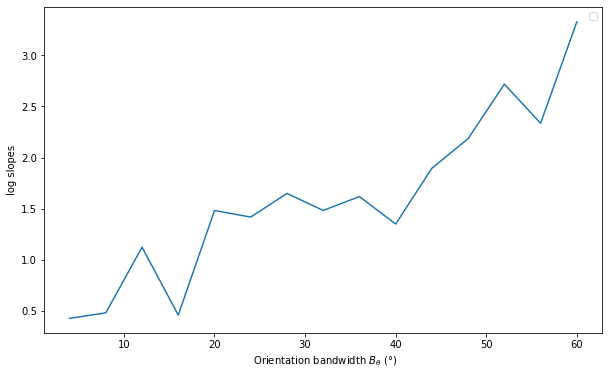

In [11]:
plt.figure(figsize=(10,6))
x = [4,8,12,16,20,24,28,32,36,40,44,48,52,56,60]
y= [1.532,1.6172,3.075,1.5822,4.4006,4.1274,5.2028,4.405,5.0456,3.856,6.6582,8.8942,15.1616,10.3415,27.88925] #mean slope for all the participants
plt.plot(x,np.log(y))
plt.xlabel(r' Orientation bandwidth $B_\theta$ (°)')
plt.ylabel(r'log slopes')
plt.legend(loc ='best');

--> observer num 0
--> observer num 1
--> observer num 2
--> observer num 3
--> observer num 4


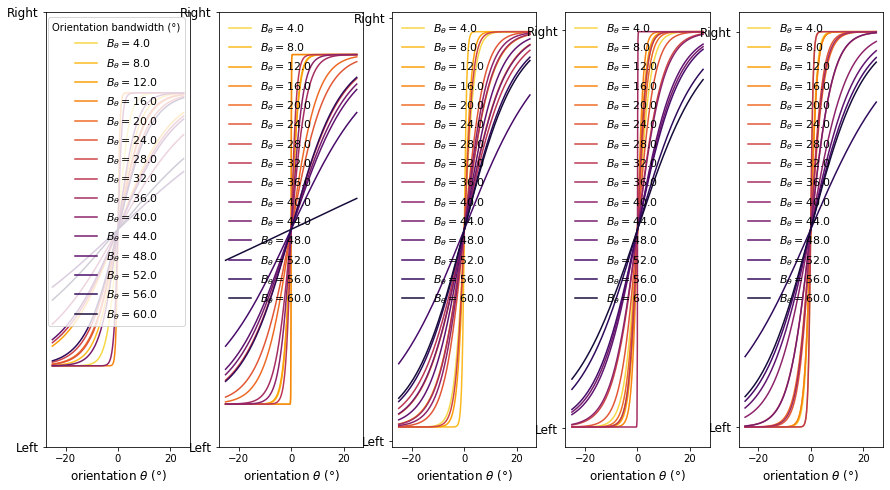

In [12]:
fig, axs = plt.subplots(len(B_sf_list), len(subj_data_list), figsize=(15, 8))
colors = plt.cm.inferno(np.linspace(.9, .1, len(B_theta_list)))
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    x_values = np.linspace(-25, 25, 400)

    for i_B_sf, B_sf in enumerate(B_sf_list):
        if len(subj_data_list)>1:
            ax = axs[num]
        else:
            ax = axs
        #colors = plt.cm.inferno(np.linspace(1, .2, len(B_thetas))) #tc colormap

        for i_B_theta, B_theta in enumerate(B_theta_list):
            #color = colors[i_B_theta]
            i_condition = i_B_theta + i_B_sf*len(B_theta_list)
            conditions = i_condition*np.ones_like(x_values)
            y_values = results[num](torch.Tensor(x_values), 
                                      torch.ByteTensor(conditions)).detach().numpy()
            ax.plot(x_values, y_values, label=r'$B_\theta=%s$' % f'{B_theta:.1f}',color=colors[i_B_theta])

        ax.set_xlabel(r"orientation $\theta$ (°)", fontsize=12)
        ax.set_yticks([0.0, 1.0])
        ax.set_yticklabels(["Left", "Right"], fontsize=12)
        ax.legend(fontsize=11, frameon=False, scatterpoints=6)
        if num==0:  ax.legend(fontsize=11, frameon=True, scatterpoints=6,title="Orientation bandwidth (°)")
        #ax.text(14, 0.1, f'B_sf = {B_sf:.3f}', fontsize=12)
        plt.savefig("Btheta_JF.pdf")

No handles with labels found to put in legend.


--> observer num 0
slope = 2.070, 4.046, 9.809, 0.399, 4.987, 4.830, 5.821, 10.523, 14.620, 0.795, 3.467, 11.162, 27.695, 6.288, 21.797
p0 = 0.372
--> observer num 1
slope = 0.052, 1.409, 1.481, 0.045, 4.974, 6.443, 9.581, 1.038, 3.012, 2.239, 10.485, 11.368, 15.477, 9.384, 69.862
p0 = 0.196
--> observer num 2
slope = 1.936, 0.485, 1.349, 5.126, 7.354, 3.796, 1.669, 8.318, 5.031, 4.469, 7.435, 6.266, 15.086, 9.348, 9.831
p0 = 0.066
--> observer num 3
slope = 2.480, 1.661, 1.505, 1.110, 2.011, 3.253, 4.737, 1.661, 0.046, 4.970, 7.728, 7.295, 8.150, 11.108, 12.619
p0 = 0.007
--> observer num 4
slope = 1.122, 0.485, 1.231, 1.231, 2.677, 2.315, 4.206, 0.485, 2.519, 6.807, 4.176, 8.380, 9.400, 16.346, 10.067
p0 = 0.001


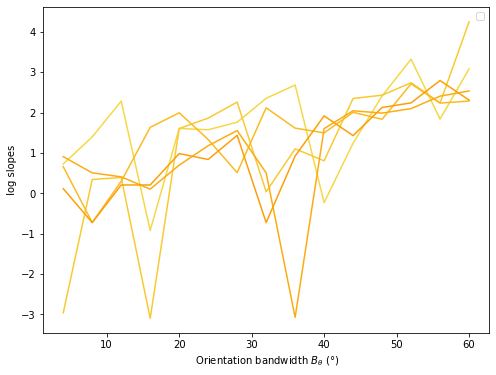

In [18]:
plt.figure(figsize = (8,6)) 

for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    colors = plt.cm.inferno(np.linspace(.9, .5, len(B_theta_list)))
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    for i_B_sf, B_sf in enumerate(B_sf_list):
        wt__ = wt_[(i_B_sf*len(B_theta_list)):((i_B_sf+1)*len(B_theta_list))]
        plt.plot(B_theta_list, np.log(wt__),color=colors[num])
plt.xlabel(r' Orientation bandwidth $B_\theta$ (°)')
plt.ylabel(r' log slopes ')
plt.legend(loc ='best');

--> observer num 0
slope = 2.070, 4.046, 9.809, 0.399, 4.987, 4.830, 5.821, 10.523, 14.620, 0.795, 3.467, 11.162, 27.695, 6.288, 21.797
p0 = 0.372
--> observer num 1
slope = 0.052, 1.409, 1.481, 0.045, 4.974, 6.443, 9.581, 1.038, 3.012, 2.239, 10.485, 11.368, 15.477, 9.384, 69.862
p0 = 0.196
--> observer num 2
slope = 1.936, 0.485, 1.349, 5.126, 7.354, 3.796, 1.669, 8.318, 5.031, 4.469, 7.435, 6.266, 15.086, 9.348, 9.831
p0 = 0.066
--> observer num 3
slope = 2.480, 1.661, 1.505, 1.110, 2.011, 3.253, 4.737, 1.661, 0.046, 4.970, 7.728, 7.295, 8.150, 11.108, 12.619
p0 = 0.007
--> observer num 4
slope = 1.122, 0.485, 1.231, 1.231, 2.677, 2.315, 4.206, 0.485, 2.519, 6.807, 4.176, 8.380, 9.400, 16.346, 10.067
p0 = 0.001


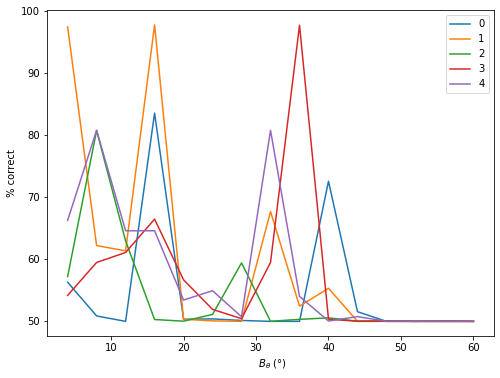

In [16]:
plt.figure(figsize = (8,6)) 
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    for i_B_sf, B_sf in enumerate(B_sf_list):
        wt__ = wt_[(i_B_sf*len(B_theta_list)):((i_B_sf+1)*len(B_theta_list))]
        correct = .5+ .5*np.exp(-wt__)
        plt.plot(B_theta_list, correct*100, label=num)
plt.xlabel(r' $B_\theta$ (°)')
plt.ylabel(r' % correct ')
plt.legend(loc ='best');

In [ ]:
cols = plt.cm.viridis(np.linspace(.2, .8, len(B_sf_list)))
plt.figure(figsize=(8,6))
for i_B_sf, B_sf in enumerate(B_sf_list) :
    Bsf_lst = []
    for num, data in enumerate(subj_data_list) :
        theta0_, wt_, p0_ = get_params(results[num], verbose=False)
        wt__ = wt_[(i_B_sf*len(B_theta_list)):((i_B_sf+1)*len(B_theta_list))]
        Bsf_lst.append(np.log(wt__))
    
        mean = np.mean(Bsf_lst, axis = 1)
        std = np.std(Bsf_lst, axis = 1)
    
    plt.plot(B_theta_list, mean, label=num)
    #plt.fill_between(B_theta_list, y1 = mean - std, y2 = mean + std, color = cols[i_sf])
    plt.legend(loc="lower left",fontsize='9');
    plt.xlabel(r' Orientation bandwidth $B_\theta$ (°)')
    plt.ylabel(r' log slope ')